In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import os
import sys
from pymongo import MongoClient

sys.path.append('..')

MONGODB_URI = os.environ.get('MONGODB_URI')
database = ''.join(MONGODB_URI.rsplit('/')[-1:])
conn = MongoClient(host=MONGODB_URI)
mongodb = conn[database]


In [68]:
from carrega_modelo_final_rc import ModelContaminado

model = ModelContaminado()

In [84]:
from atualiza_mongo_rc import ComunicaReeeferContaminado

comunicador = ComunicaReeeferContaminado(model, mongodb)
def print_one():
    registro = next(comunicador.cursor)
    _id = registro['_id']
    predictions_reefer = registro['metadata']['predictions'][0]['reefer'][0]
    print(_id, predictions_reefer)
    comunicador.get_pil_image(_id)
    print(model.predict(comunicador.pil_image))


INFO:root:Consulta ao banco efetuada.


603cee9bbeb63828c35eb7a6 {'reefer_bbox': [65.21646881103516, 8.310043334960938, 152.1454315185547, 614.7932739257812], 'reefer_class': 0, 'reefer_score': 0.9907009601593018}
False


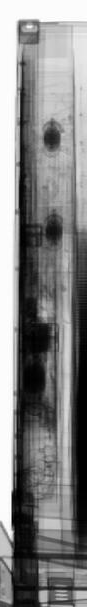

In [85]:
print_one()
comunicador.pil_image

603cee9bbeb63828c35eb756 {'reefer_bbox': [1637.6048583984375, 16.110485076904297, 1722.7371826171875, 614.8853759765625], 'reefer_class': 0, 'reefer_score': 0.9876108765602112}
False


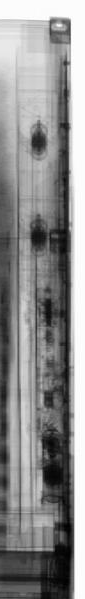

In [86]:
print_one()
comunicador.pil_image

In [217]:
import io
from PIL import Image, ImageDraw
from gridfs import GridFS

fs = GridFS(mongodb)

def pil_image_bbox(_id, coords):
    pil_image = Image.open(io.BytesIO(fs.get(_id).read()))
    draw = ImageDraw.Draw(pil_image)
    draw.rectangle((coords[0] -2, coords[1] - 2, coords[2] + 2, coords[3] + 2),
                    outline='#2288EE', width=4)
    return pil_image

def print_one_2(cursor):
    registro = next(cursor)
    _id = registro['_id']
    reefer = registro['metadata']['predictions'][0]['reefer']
    print(_id, reefer)
    pil_image = pil_image_bbox(_id, reefer[0]['reefer_bbox'])
    return pil_image

FILTRO_CONTAMINADO = {'metadata.contentType': 'image/jpeg',
          'metadata.predictions.reefer.reefer_bbox': {'$exists': True},
          'metadata.predictions.reefer.reefer_contaminado': True}

FILTRO_N = {'metadata.contentType': 'image/jpeg',
          'metadata.predictions.reefer.reefer_bbox': {'$exists': True},
          'metadata.predictions.reefer.reefer_contaminado': False}

cursor_contaminado = mongodb['fs.files'].find(FILTRO_CONTAMINADO, {'metadata.predictions': 1})
cursor_nao = mongodb['fs.files'].find(FILTRO_N, {'metadata.predictions': 1})

603cee3ebeb63828c35eaf82 [{'reefer_bbox': [96.52944946289062, 15.412737846374512, 163.51425170898438, 681.591064453125], 'reefer_class': 0, 'reefer_score': 0.9887963533401489, 'reefer_contaminado': True}]


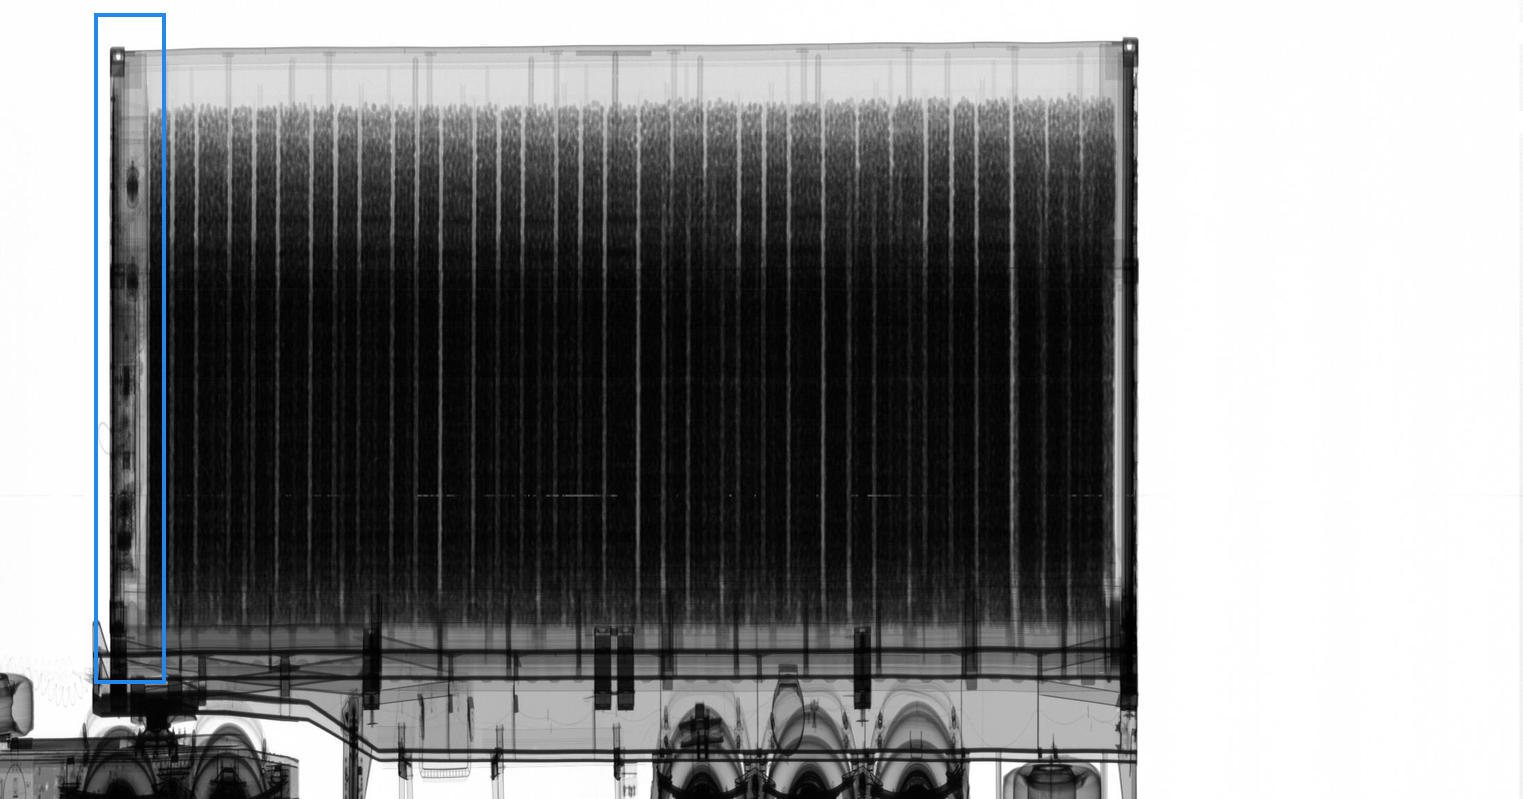

In [218]:
print_one_2(cursor_contaminado)

603cee3cbeb63828c35eaebe [{'reefer_bbox': [168.5514373779297, 14.99242115020752, 253.7230987548828, 635.4952392578125], 'reefer_class': 0, 'reefer_score': 0.9765857458114624, 'reefer_contaminado': False}]


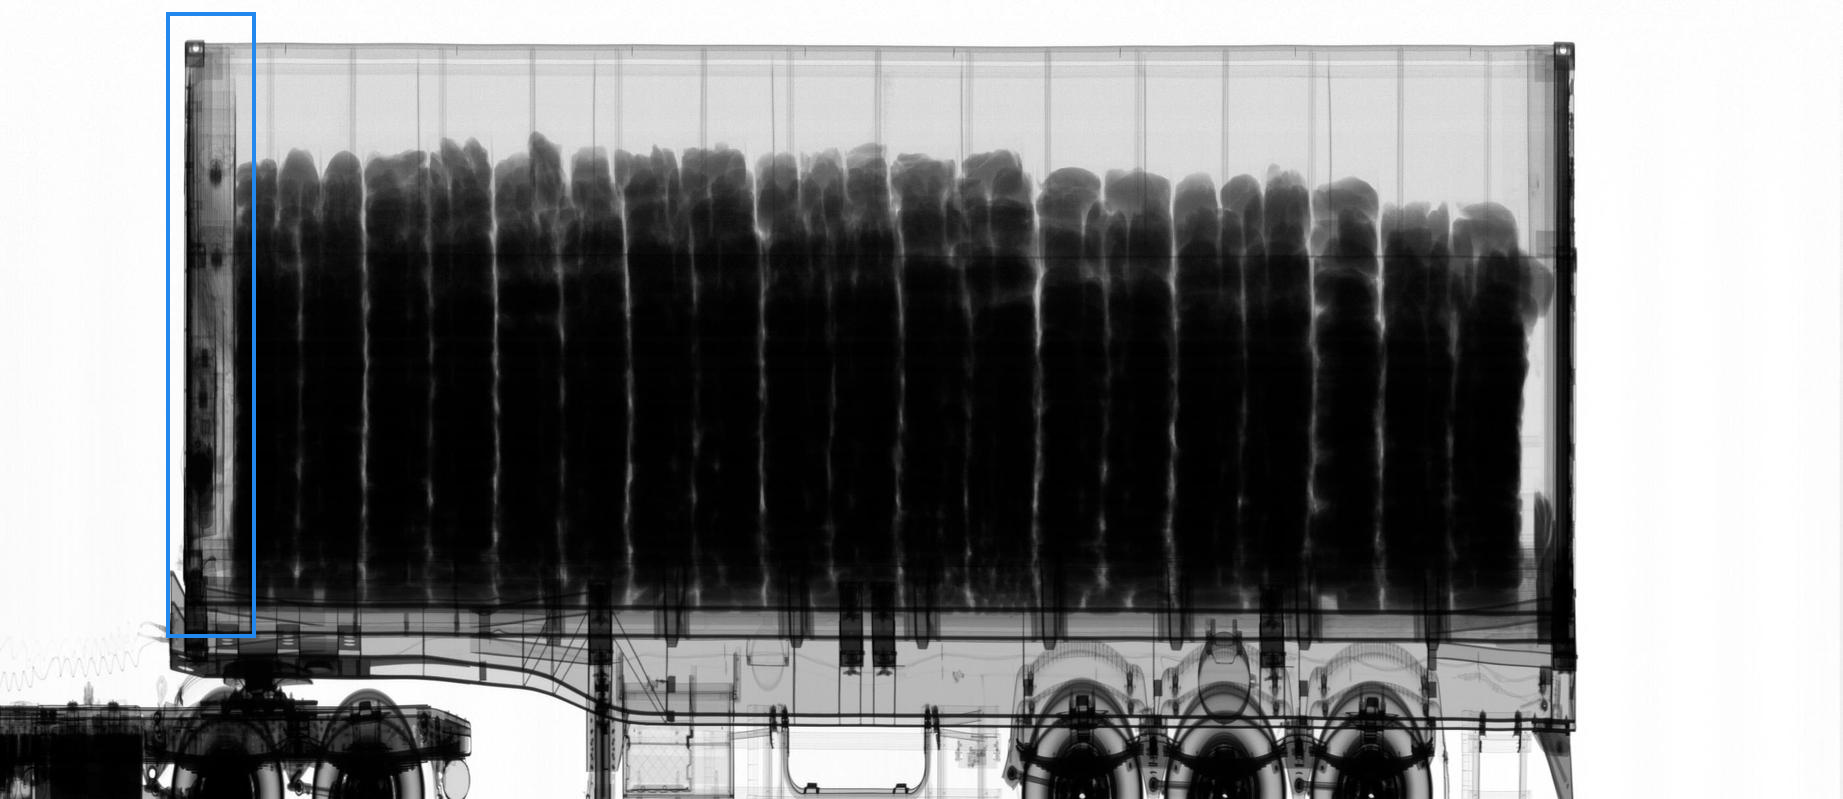

In [219]:
print_one_2(cursor_nao)